# Section 1: Dataset Selection & Cleaning

Load Dataset Into Dataframe

In [ ]:
import pandas as pd
import json

with open("/content/drive/MyDrive/Indonesian News Corpus Dataset/november.json", "r") as file:
    data = json.load(file)
df = pd.DataFrame(data, columns=["isi", "kategori"])
print(df.head())


                                                 isi        kategori
0  TRIBUNNEWS.COM, JAKARTA - Anggota Komisi VII D...  Bisnis Ekonomi
1  TRIBUNNEWS.COM, JAKARTA - Anggota Komisi VII D...  Bisnis Ekonomi
2  TRIBUNNEWS.COM, JAKARTA - Pengamat Ekonomi dar...  Bisnis Ekonomi
3  TRIBUNNEWS.COM, JAKARTA - Rencana pemerintah y...  Bisnis Ekonomi
4  TRIBUNNEWS.COM, JAKARTA - Sebagai bentuk konsi...  Bisnis Ekonomi


Data Preprocessing

In [ ]:
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK data (run this once)
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load Indonesian stopwords from NLTK or define custom stopword list
indonesian_stopwords = set(stopwords.words('indonesian'))

# Text preprocessing function: lowercasing, tokenization, and stopword removal
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    return ' '.join(tokens)

# Apply preprocessing to the 'isi' column (article content)
df['cleaned_isi'] = df['isi'].apply(preprocess_text)

# Split into training (70%), validation (10%), and test (20%) sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_isi'], df['kategori'], test_size=0.3, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=2/3, random_state=42)  # Split remaining 30% into 10% and 20%

# Print the sizes of each set to verify the split
print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Training set size: 16934
Validation set size: 2419
Test set size: 4839


# Section 2: Methods

## 2.1 SVM + TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=15000)

X_train_tfidf = vectorizer.fit_transform(train_texts)
X_val_tfidf = vectorizer.fit_transform(val_texts)
X_test_tfidf = vectorizer.fit_transform(test_texts)

Modeling using SVM + TF-IDF Embedding

In [ ]:
from sklearn.svm import LinearSVC

y_train = train_labels
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

Validation Accuracy: 0.4386109962794543
Validation Report:
                 precision    recall  f1-score   support

Bisnis Ekonomi       0.16      0.06      0.08       417
          Bola       0.28      0.10      0.15       345
     Lifestyle       0.03      0.01      0.02        95
      Nasional       0.49      0.86      0.63      1148
      Olahraga       0.12      0.01      0.02       164
      Otomotif       0.33      0.01      0.03        71
     Teknologi       0.09      0.05      0.06        96
        Travel       0.15      0.05      0.07        83

      accuracy                           0.44      2419
     macro avg       0.21      0.14      0.13      2419
  weighted avg       0.33      0.44      0.34      2419

Testing Accuracy: 0.45153957429220914
Testing Report:
                 precision    recall  f1-score   support

Bisnis Ekonomi       0.17      0.13      0.15       773
          Bola       0.34      0.09      0.14       686
     Lifestyle       0.00      0.00      

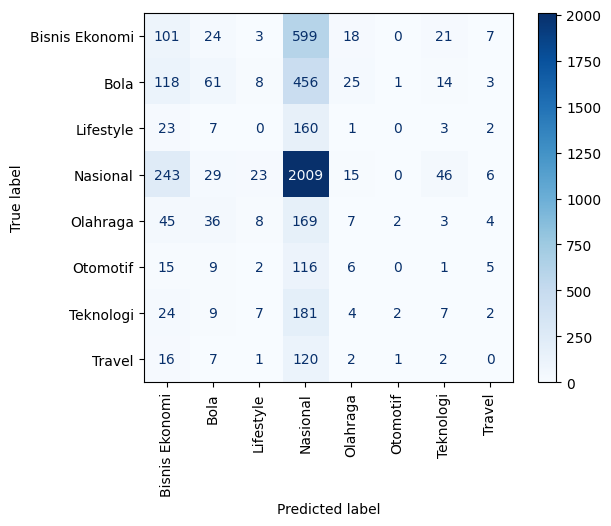

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Prediksi pada validation set
y_val = val_labels
y_val_pred = svm_model.predict(X_val_tfidf)

# Evaluasi performa
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Report:\n", classification_report(y_val, y_val_pred))

#Prediksi pada testing set
y_test = test_labels
y_test_pred = svm_model.predict(X_test_tfidf)

# Evaluasi performa
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("Testing Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
disp.plot(cmap="Blues", xticks_rotation='vertical')
